In [1]:
import json
import pandas as pd
from tqdm.notebook import tqdm
from SPARQLWrapper import SPARQLWrapper, JSON

/home/ins-alex/.local/lib/python3.8/site-packages/rdflib_jsonld/__init__.py:9: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.1.  Please remove rdflib-jsonld from your project's dependencies.
  warnings.warn(


In [2]:
def read_json(filename):
    with open(filename) as f:
        return json.load(f)
    
def write_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def execute(query: str, endpoint_url: str = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql', database: str = "wikidata"):
    agent_header = {'User-Agent': 'wiki_parser_online/0.17.1 (https://deeppavlov.ai;'
                                        ' info@deeppavlov.ai) deeppavlov/0.17.1'}
    sparql = SPARQLWrapper(endpoint_url)
    sparql.agent = str(agent_header)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    response = sparql.query().convert()
    return response

def transform_sparql_json_to_dataframe(response: dict):
    data = response["results"]["bindings"]
    df_dict = dict()
    for i in data:
        for k, v in i.items():
            if k not in df_dict.keys():
                df_dict[k] = list()
            df_dict[k].append(v.get("value"))
    return pd.DataFrame.from_dict(df_dict)

In [3]:
mintaka_dev = read_json('../data/original/mintaka_dev.json')
mintaka_train = read_json('../data/original/mintaka_train.json')
mintaka_test = read_json('../data/original/mintaka_test.json')

In [17]:
languages = ["ar", "de", "ja", "hi", "pt", "es", "it", "fr"]

def iterate_mintaka(mintaka, n=len(languages)//2):
    questions = list()
    for question in tqdm(mintaka):
        try:
            ## sparql query to fetch a label from wikidata
            query_part = " UNION\n".join(["{{ wd:{entity} rdfs:label ?label filter(lang(?label)='{lang}'). }}".format(lang=lang, entity=question["questionEntity"][0]["name"]) for lang in languages])        

            query = """
                PREFIX wd: <http://www.wikidata.org/entity/>
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

                SELECT DISTINCT ?labelStr
                WHERE
                {{
                    {query_part}        
                    BIND(STR(?label) as ?labelStr)

                }}
            """.format(query_part=query_part)
            
            response = execute(query)
            df = transform_sparql_json_to_dataframe(response)
            if len(df) > n:
                pass
                # print(question["questionEntity"][0]["name"])
            questions.append({"question": question, "df": df})
            
        except Exception as e:
            print(str(e))
    return questions

In [18]:
questions_dev = iterate_mintaka(mintaka_dev)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
len([q for q in questions_dev if len(q["df"]) > 0])

1963

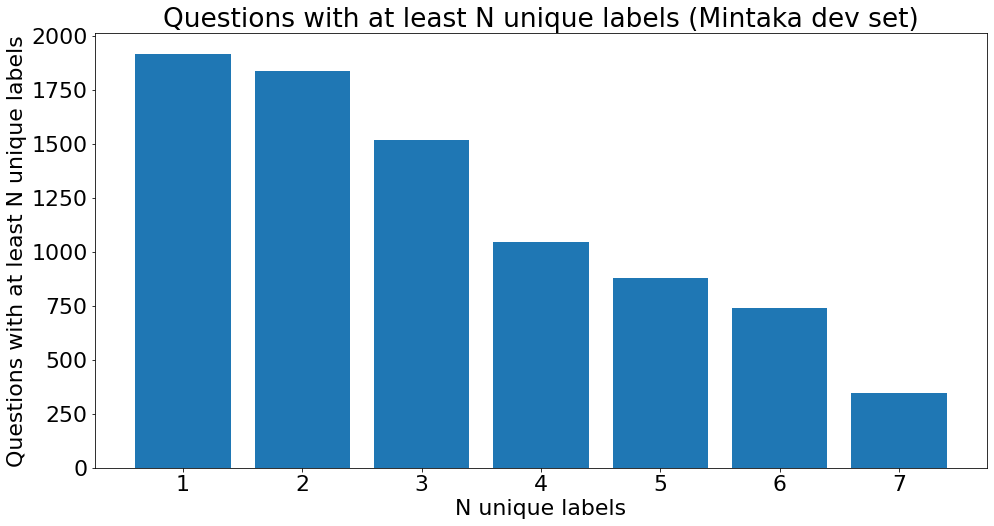

In [19]:
n_list = list()

for i in range(1, len(languages)):
    n_list.append(len([q for q in questions_dev if len(q["df"]) > i]))

# draw a bar chart
import matplotlib.pyplot as plt
# increase figure size
plt.rcParams["figure.figsize"] = (16, 8)
# increase font size
plt.rcParams.update({'font.size': 22})
plt.bar(range(1, len(languages)), n_list)
plt.title('Questions with at least N unique labels (Mintaka dev set)')
plt.xlabel('N unique labels')
plt.ylabel('Questions with at least N unique labels')
plt.show()

In [ ]:
questions_train = iterate_mintaka(mintaka_train)

{'head': {'vars': ['enLabel', 'deLabel', 'ruLabel', 'frLabel']},
 'results': {'bindings': []}}

In [ ]:
questions_test = iterate_mintaka(mintaka_test)